# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>SARIMAX</font></div>

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [3]:
# Load dataset
df = pd.read_csv('../Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspect the data
For this section we've built a Restaurant Visitors dataset that was inspired by a <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'>recent Kaggle competition</a>. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [4]:
'''
OK, so for the exactions variables, we're going to see whether or not this holiday 
column actually affects this total column.

First off, we'll do a normal seasonal Arima model and then we'll add in this 
seasonal aroma exogenous model adding in this holiday information.

'''
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [5]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [6]:
'''
So we're going to go ahead and drop that missing data since we can't really use 
it for training purposes.
'''
df1 = df.dropna()
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [7]:
df1.columns

Index(['weekday', 'holiday', 'holiday_name', 'rest1', 'rest2', 'rest3',
       'rest4', 'total'],
      dtype='object')

In [8]:
'''
So what we're going do here is we're going to change the data type of 
these last four columns, the restaurant numbers, as well as the total 
and make them into integers.



'''

# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


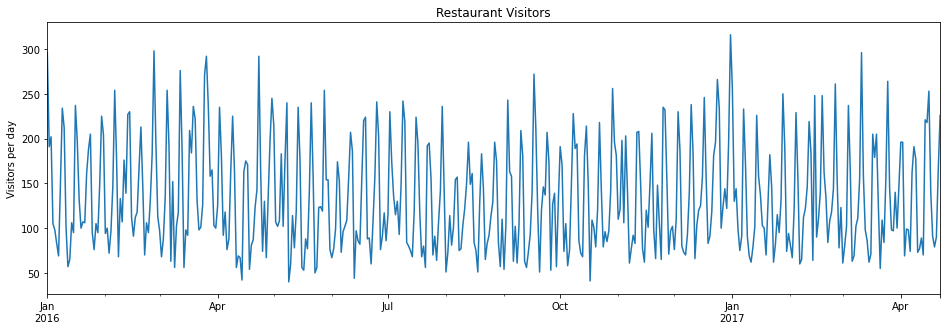

In [9]:
'''
Recall that what we're trying to do is we're trying to predict and forecast the 

total number of visitors.So let's see what that looks like over time,

It does look like there's some sort of repeating peak.

It doesn't look like it's on a monthly level.

In fact, it's probably on a weekly level.

So maybe on the weekends there's a peak or maybe on Fridays or maybe on a happy hour day.
'''
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [10]:
df1[df1['holiday']==1].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

2016-01-01 00:00:00
2016-01-18 00:00:00
2016-02-02 00:00:00
2016-02-14 00:00:00
2016-02-15 00:00:00
2016-03-17 00:00:00
2016-03-25 00:00:00
2016-03-27 00:00:00
2016-03-28 00:00:00
2016-05-05 00:00:00
2016-05-08 00:00:00
2016-05-30 00:00:00
2016-06-19 00:00:00
2016-07-04 00:00:00
2016-09-05 00:00:00
2016-10-10 00:00:00
2016-10-31 00:00:00
2016-11-11 00:00:00
2016-11-24 00:00:00
2016-11-25 00:00:00
2016-12-24 00:00:00
2016-12-25 00:00:00
2016-12-31 00:00:00
2017-01-01 00:00:00
2017-01-16 00:00:00
2017-02-02 00:00:00
2017-02-14 00:00:00
2017-02-20 00:00:00
2017-03-17 00:00:00
2017-04-14 00:00:00
2017-04-16 00:00:00
2017-04-17 00:00:00


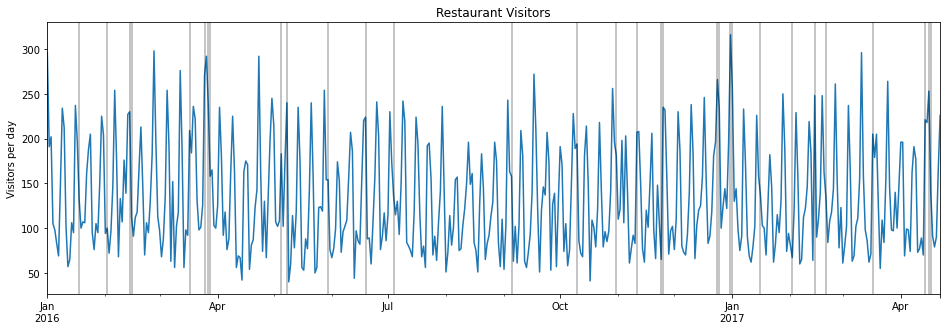

In [11]:
'''
We don't really know for sure until we zoom in.

But what I'm also going to do is I'm going to write a little bit of code here so I can overlap when

there is a holiday and see, maybe there's an effect there, maybe not.

It may be a little hard to tell visually, but hopefully when we run, our Suruma X 

model will actually be able to tell that.


df1.query('holiday==1').index

So I'm essentially going to query the data frame for when Holliday's equal to one and 
grab those index numbers.

So if you return that, it basically returns back only the dates where the one happens 
to be equal to holiday.

ax.axvline(x=x, color='k', alpha = 0.3)

And what I want to do is for all these index locations at these date time stamps, 
I want to add in a little vertical line on my plot.


We'll say ax.axvline, which basically is a matplotlib command to add a vertical line onto
this axis object And then we'll say where X is equal today(x=x).

So essentially for every day in this date time index at a vertical line and then 
we can say what color we want it to be.

It's also the color equal to black, which is just color code, or you can also type out black.
And then let's give it a little bit of transparency.

'''

title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:# for days where holiday == 1 
                                        #or df1[df1['holiday']==1].index
       ax.axvline(x=x, color='k', alpha = 0.3)
       print(x)  ;# add a semi-transparent grey line
        

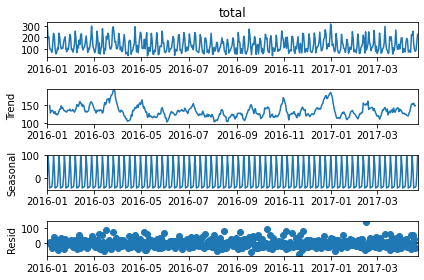

In [12]:
'''

So keep that in mind that just visually right now, it's a little unclear whether or not 

this exogenous variable is really going to be predictive of how many visitors 

show up to these restaurants.

However, intuitively, you should have some sort of idea that holidays probably do matter 

if there is a visit there or not.

Well, you also may want to do is since there is some indication of seasonality, 

is run a ETS decomposition.


So there is the observed values, 

the general trend, it looks like there's some sort of increase going on maybe during 

the holidays.A little hard to tell.

And there's definitely a seasonal component.
'''

result=seasonal_decompose(df1['total'])
result.plot();

<AxesSubplot:xlabel='date'>

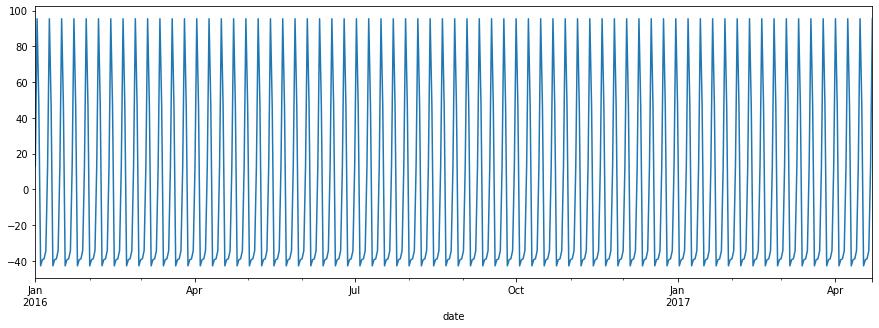

In [13]:
'''
So very strong seasonal component.

In fact, let's just take a look at that seasonal component


we can see the peaks and valleys here, and what you

can do is eventually if you kind of zoom in on the seasonal component, you'll 

notice that it's it's weekly.

And in fact, you can kind of just tell that there's four seasonal periods per month 

indicating that there's four weeks per month.

So the seasonality of this data happens to be on a weekly basis, which makes sense.
'''
result.seasonal.plot(figsize=(15,5))

### Test for stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [15]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [16]:
'''
And since we believe it to be weekly, given the plots that we just saw of, say,
M is equal to seven.
'''

# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2383.417
Date:                             Fri, 05 Nov 2021   AIC                           4776.834
Time:                                     21:08:51   BIC                           4797.682
Sample:                                          0   HQIC                          4785.030
                                             - 478                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.8706      2.094      3.281      0.001       2.767      10.975
ar.L1          0.1549      0.047      3.272      0.001       0.062       0.248
ar.S.L7        0.9436      0.017     55.586      0.000       0.910       0.977
ma.S.L7       -0.6912      0.057    -12.084      0.000      -0.803      -0.579
sigma2      1308.0797     83.835     15.603      0.000    1143.766    1472.393
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                60.79
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.72
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Excellent! This provides an ARIMA Order of (1,0,0) and a seasonal order of (2,0,0,7) Now let's train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variable.
### Split the data into train/test sets
We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [17]:
'''
we're first

going to fit to just a classic Suruma based model.

So we'll just take a seasonal or remodel and see how it performs.

So the first thing going to do is do a train test split.

So we're going to try to forecast a month into the future for restaurant visits, 

which means our test set should also be about a month.
'''
len(df1)

478

In [18]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### Fit a SARIMA(1,0,0)(1,0,1,7) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [19]:
'''

So we already split the data into a training set and a test set, and now we have our orders.

So it's time to actually fit this model.

now I'm only passing in the training data that it can fairly evaluate this model,


my order for the p,d,q terms, for the Arima portion of the model are just (1, 0, 0) which 

was reported back by auto Arima.

for the seasonal order of the model will go ahead say (1,0,1,7)

enforce_invertibility=False:

And then the last parameter I need to provide here is this parameter of 
inforce Inevitability.

Now, the reason we have to enforce convertibility equal to false here is mainly 

due to the way built stat's models library.

Essentially, we already know about the auto regression representation, where the most 
recent error can be written as a linear function of current and past observations.

So we already know that we can write out this linear function.

And the key part is for inconvertible process.Theta here is less than one.
And so the most recent observations have higher weight than observations from the more 
distant past.

Which makes sense, right?

That more recent data should hold the higher weight then further out data into the past.

However, when you have a process where theta is greater than one, then the weights 
increase as lags increase, which actually means the opposite.

That the more distance observations have greater influence on the current error, 
which is sometimes a peculiar situation.

And when Theta is equal to exactly one, then the weights are constant and size and the 
distance observations have the same influence as the recent observations.

So these last two situations typically don't make much sense, and so we prefer this 
inevitable process.

However, the way that stat's models has built out the Sorina X model internally 
It will try to force convertibility by forcing this theta to be less than one.
And in some particular situations, that actually doesn't make sense and it'll force an error.

So what we're going to do here is in order to avoid all those issues, we'll say 
in force convertibility equal to false and a way to understand whether or not you 
need to do that is simply run the model and see if you get the error.

And the error you get is called value error, non-convertible starting M.A parameters found.

So again, if you ever get the error.
When you're running one of these models that auto Auriemma suggested of value error, 
non-convertible starting M.A parameters found, that's totally OK.

Just inside your SARIMAX call, go ahead and say inforce inevitability equal to 
false and then that should remove that error.



'''

model=SARIMAX(train["total"],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2155.511
Date:                             Fri, 05 Nov 2021   AIC                           4319.023
Time:                                     21:08:52   BIC                           4335.333
Sample:                                 01-01-2016   HQIC                          4325.460
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2194      0.043      5.066      0.000       0.134       0.304
ar.S.L7        0.9999      0.000   8030.968      0.000       1.000       1.000
ma.S.L7       -0.9405      0.023    -40.032      0.000      -0.987      -0.894
sigma2      1068.8607     54.345     19.668      0.000     962.347    1175.375
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):               106.77
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.77
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
'''
And we're going to do now is get predicted values into the future for our test set.

'''
start=len(train)
end=len(train)+len(test)-1

predictions=results.predict(start,end,dynamic=False).rename('SARIMA(1,0,0)(1,0,1,7) Predictions')
predictions

2017-03-12    186.299776
2017-03-13     90.983422
2017-03-14    100.282670
2017-03-15     96.887929
2017-03-16     98.668837
2017-03-17    140.773517
2017-03-18    235.254904
2017-03-19    172.957319
2017-03-20     88.049485
2017-03-21     99.627730
2017-03-22     96.733688
2017-03-23     98.624075
2017-03-24    140.746883
2017-03-25    235.220214
2017-03-26    172.932581
2017-03-27     88.036986
2017-03-28     99.613652
2017-03-29     96.720030
2017-03-30     98.610154
2017-03-31    140.727017
2017-04-01    235.187013
2017-04-02    172.908172
2017-04-03     88.024559
2017-04-04     99.599592
2017-04-05     96.706379
2017-04-06     98.596235
2017-04-07    140.707153
2017-04-08    235.153817
2017-04-09    172.883767
2017-04-10     88.012135
2017-04-11     99.585534
2017-04-12     96.692729
2017-04-13     98.582318
2017-04-14    140.687293
2017-04-15    235.120626
2017-04-16    172.859364
2017-04-17     87.999712
2017-04-18     99.571477
2017-04-19     96.679081
2017-04-20     98.568404


Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

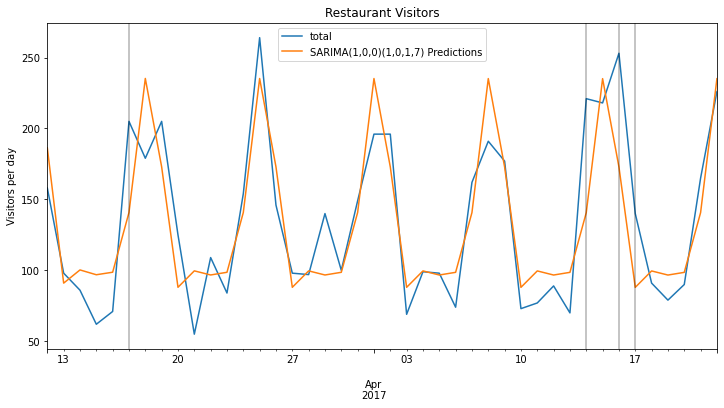

In [21]:
'''

So we can see here in that second week, we're really doing quite well.

But you know this for this particular week, there's a dip or maybe even a peak that 
we didn't actually grab.

So would it be interesting to see if for the situations where we didn't do such a 
great job predicting? 


And now we can see there was one holiday here that we didn't pick up on and there's 
three holidays here in the USA for this last one, and you'll notice it kind of like 
converges with these peaks.

So it'll be interesting to see if adding in the holidays as exogenous variables 
would actually improve our model.
'''

# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### Evaluate the Model

In [22]:
'''
The last thing I want to do is evaluate the model quantitatively 
using root mean squared error.
'''

from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(1,0,1,7) MSE Error:  1022.06206
SARIMA(1,0,0)(1,0,1,7) RMSE Error: 31.96970535


## Now add the exog variable

In [23]:
'''
So so far, we've only run screamo based models on our data with a seasonal 

component and the basic Arima components.

Now we're going to add in the exegonous variable.

In our case, it's going to be that holiday data.

'''

model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2089.208
Date:                             Fri, 05 Nov 2021   AIC                           4188.417
Time:                                     21:16:13   BIC                           4208.805
Sample:                                 01-01-2016   HQIC                          4196.463
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9352      3.773     18.271      0.000      61.540      76.330
ar.L1          0.2101      0.044      4.762      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3164     44.867     17.369      0.000     691.379     867.254
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                20.47
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(1,0,1,7)) Predictions')

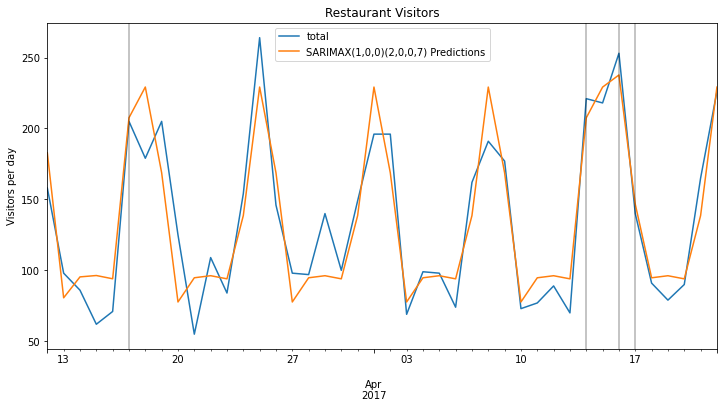

In [25]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [26]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(1,0,1,7)) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(1,0,1,7)) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error:  1022.06206
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 31.96970535

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 525.7736277
SARIMAX(1,0,0)(2,0,0,7) RMSE Error:  22.9297542


### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days into the future, and use the additional holiday data

In [31]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(1,0,1,7)) Forecast')

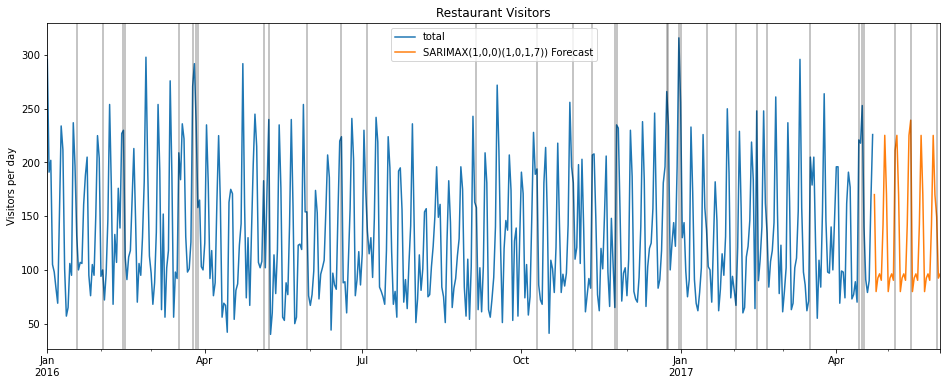

In [32]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);